# library

In [3]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

# GPU 확인

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # 메모리 사용 제한을 위한 설정
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    # 특정 GPU만 사용하도록 설정
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
  except RuntimeError as e:
    # 프로그램 시작 후에는 GPU 설정을 변경할 수 없으므로
    # 런타임 오류 발생 시 예외 처리가 필요함
    print(e)

Num GPUs Available:  1


# Dataset

In [6]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

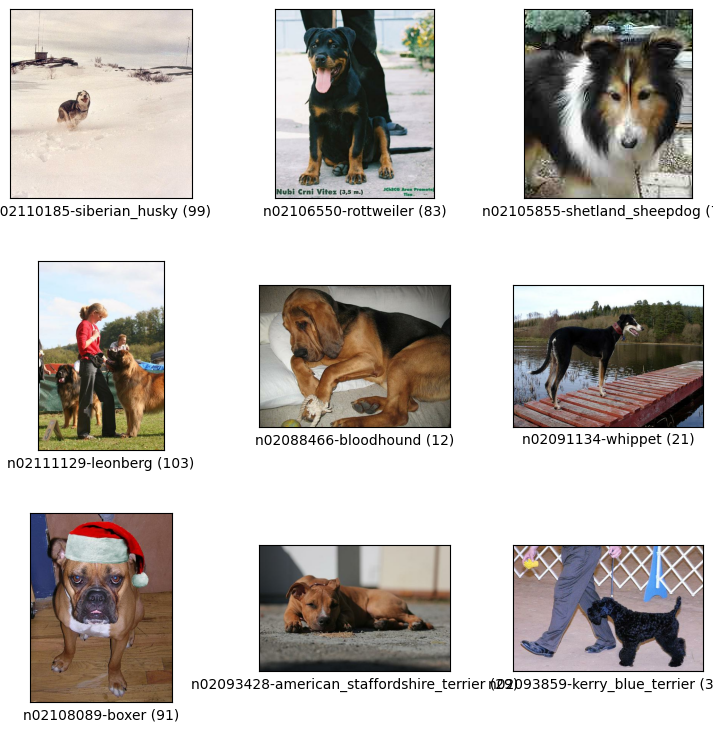

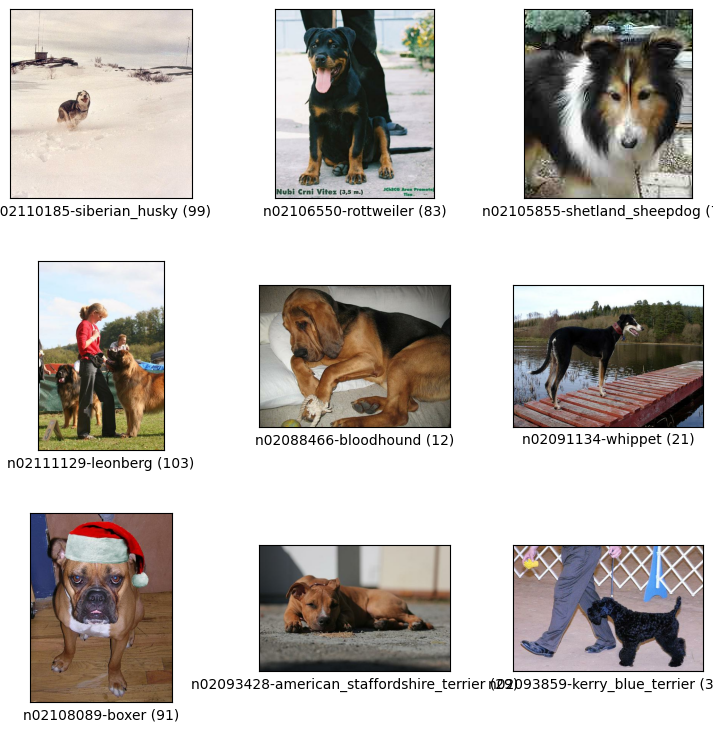

In [5]:
tfds.show_examples(ds_train, ds_info)

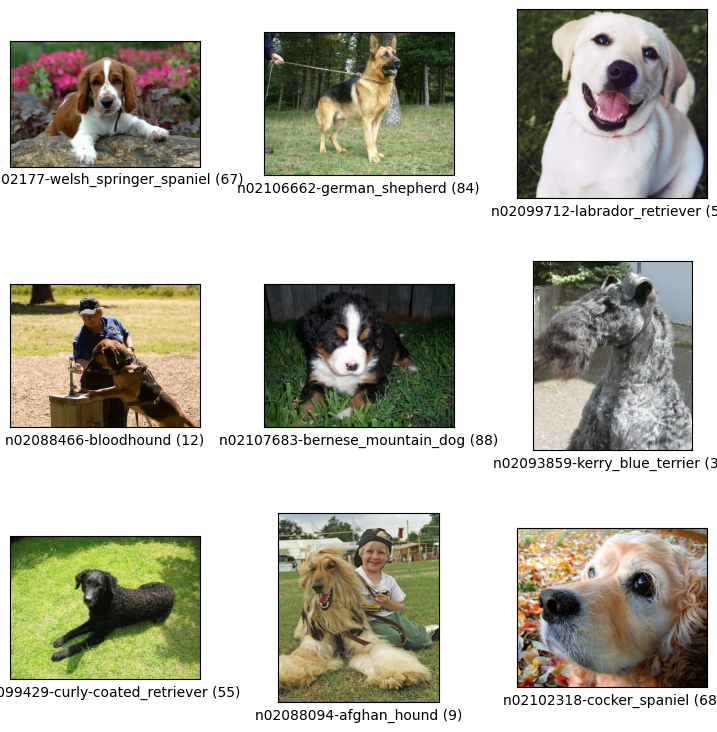

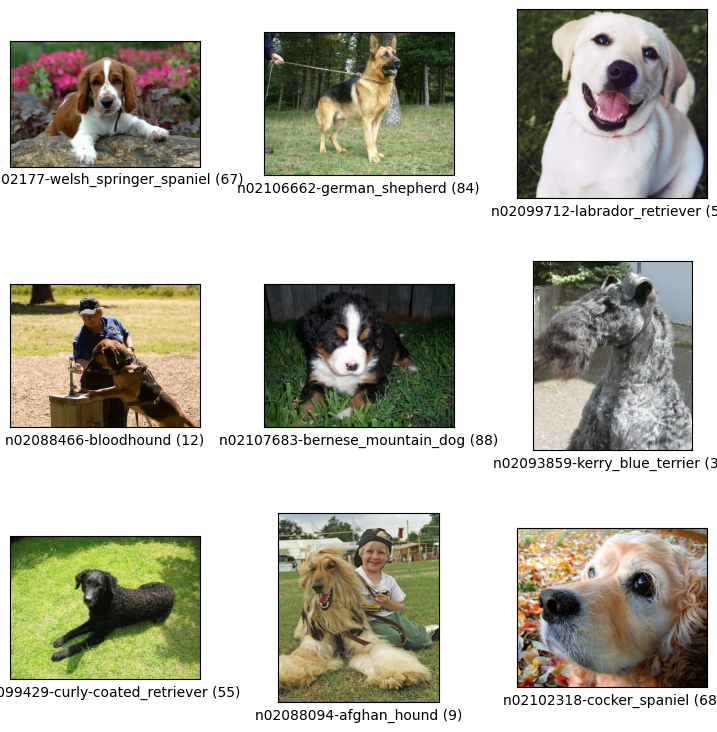

In [6]:
tfds.show_examples(ds_test,ds_info)

In [7]:
print(ds_info)

tfds.core.DatasetInfo(
    name='stanford_dogs',
    full_name='stanford_dogs/0.2.0',
    description="""
    The Stanford Dogs dataset contains images of 120 breeds of dogs from around the
    world. This dataset has been built using images and annotation from ImageNet for
    the task of fine-grained image categorization. There are 20,580 images, out of
    which 12,000 are used for training and 8580 for testing. Class labels and
    bounding box annotations are provided for all the 12,000 images.
    """,
    homepage='http://vision.stanford.edu/aditya86/ImageNetDogs/main.html',
    data_dir=PosixGPath('/tmp/tmphvq0rek_tfds'),
    file_format=tfrecord,
    download_size=778.12 MiB,
    dataset_size=744.72 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=120),
        'objects': Sequence({
            'bbox': BBoxFeature(sh

In [8]:
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'image/filename': Text(shape=(), dtype=string),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=float32),
    }),
})


In [9]:
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(12000, shape=(), dtype=int64)
tf.Tensor(8580, shape=(), dtype=int64)


In [10]:
len(ds_info.features['label'].names)

120

In [11]:
ds_info.features['label'].names

['n02085620-chihuahua',
 'n02085782-japanese_spaniel',
 'n02085936-maltese_dog',
 'n02086079-pekinese',
 'n02086240-shih-tzu',
 'n02086646-blenheim_spaniel',
 'n02086910-papillon',
 'n02087046-toy_terrier',
 'n02087394-rhodesian_ridgeback',
 'n02088094-afghan_hound',
 'n02088238-basset',
 'n02088364-beagle',
 'n02088466-bloodhound',
 'n02088632-bluetick',
 'n02089078-black-and-tan_coonhound',
 'n02089867-walker_hound',
 'n02089973-english_foxhound',
 'n02090379-redbone',
 'n02090622-borzoi',
 'n02090721-irish_wolfhound',
 'n02091032-italian_greyhound',
 'n02091134-whippet',
 'n02091244-ibizan_hound',
 'n02091467-norwegian_elkhound',
 'n02091635-otterhound',
 'n02091831-saluki',
 'n02092002-scottish_deerhound',
 'n02092339-weimaraner',
 'n02093256-staffordshire_bullterrier',
 'n02093428-american_staffordshire_terrier',
 'n02093647-bedlington_terrier',
 'n02093754-border_terrier',
 'n02093859-kerry_blue_terrier',
 'n02093991-irish_terrier',
 'n02094114-norfolk_terrier',
 'n02094258-norwi

# Data preprocessing

In [16]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label


# Augmentation

In [17]:
def augment(image, label) :
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta = 0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

* augmentation 적용 함수

    * 텐서플로우 Random Augmentation API 종류
    
        * random_brightness(): 명도 조절
        * random_brightness(): 명도 조절
        * random_contrast(): 대비 조절
        * random_crop(): 자르기
        * random_flip_left_right(): 좌우 대칭
        * random_flip_up_down(): 상하 대칭
        * random_hue(): 색상 조절
        * random_jpeg_quality(): jpeg 인코딩 품질 변경
        * random_saturation(): 채도 조절

# Cutmix

In [7]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]

    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)

    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+height//2)

    return x_min, y_min, x_max, y_max

In [8]:
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)

    return mixed_img

In [9]:
def mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

In [10]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

# Mixup

In [11]:
def mixup_2_images(image_a, image_b, label_a, label_b, num_classes = 120):
    ratio = tf.random.uniform([], 0, 1)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b

    return mixed_image, mixed_label

In [12]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

# Onehot Encoding

In [13]:
def onehot(image, label, num_classes = 120):
    label = tf.one_hot(label, num_classes)
    return image, label

# Dataset preprocessing

In [14]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup = False):
    ds = ds.map(
        normalize_and_resize_img,
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
##----------------------
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup :
        ds =ds.map(
            mixup,
            num_parallel_calls =2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
#---------------
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [18]:
ds_train_no = apply_normalize_on_dataset(ds_train)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug = True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_aug = True, with_cutmix = True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_aug = True, with_mixup = True)
ds_test = apply_normalize_on_dataset(ds_test, is_test = True)

# Data 확인

In [19]:
def draw_ds(ds_train, batch_size = 16, row =4, col =4) :
    for i, (image, label) in enumerate(ds_train.take(1)) :
        plt.figure(figsize = (8,8))
        for j in range(16):
            plt.subplot(row, col, j+1)
            plt.axis('off')
            plt.imshow(image[j,])

        plt.tight_layout()
        plt.show()

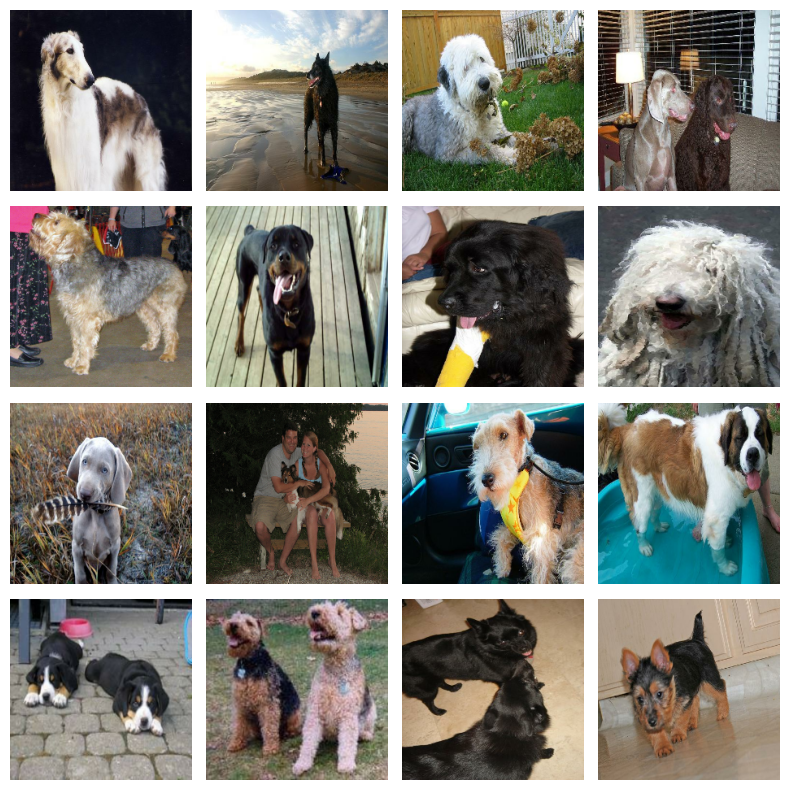

In [24]:
draw_ds(ds_train_no)

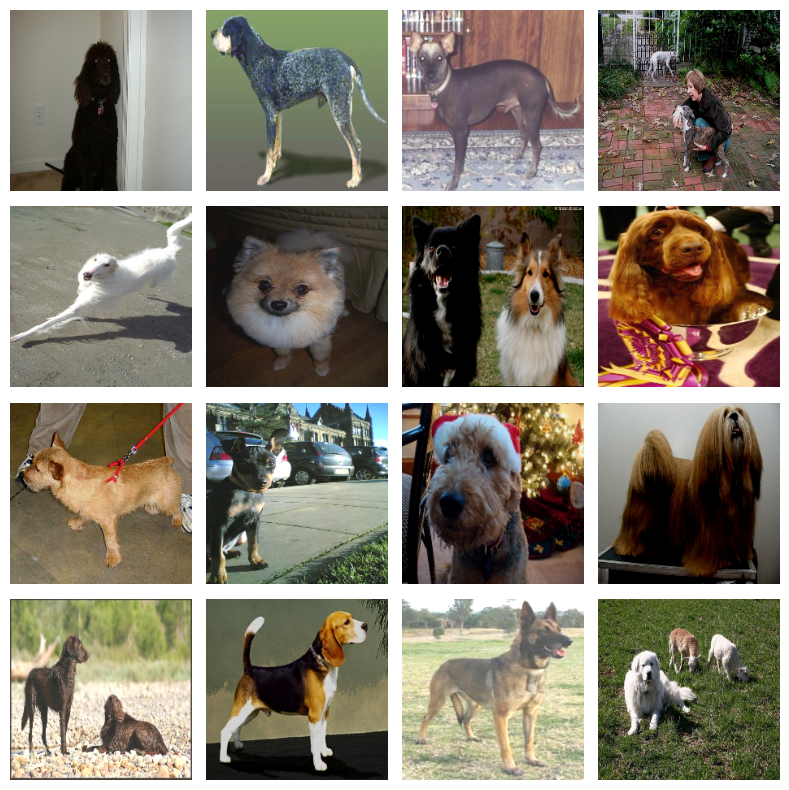

In [25]:
draw_ds(ds_train_aug)

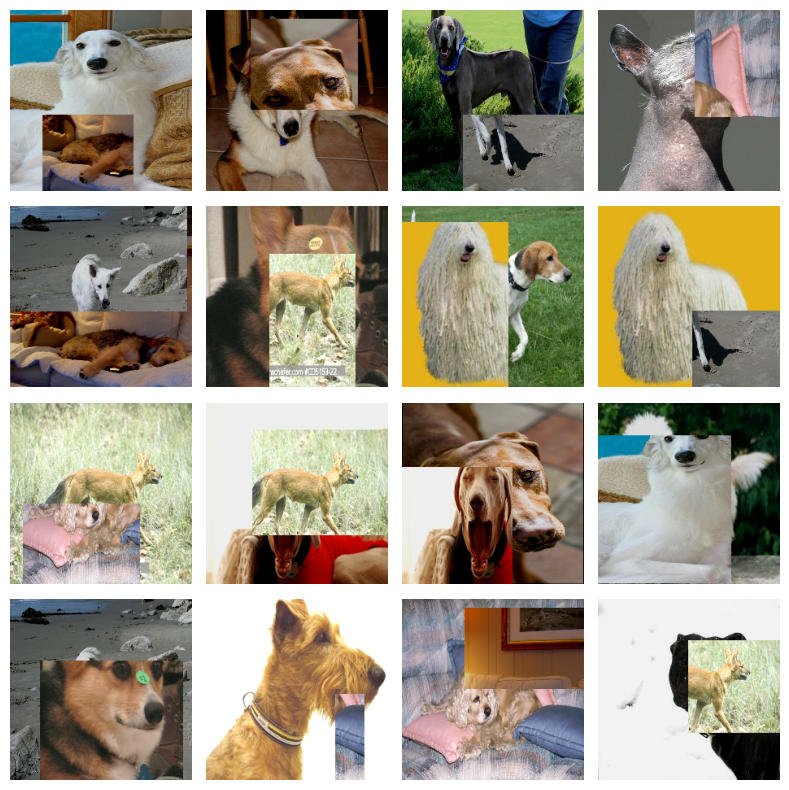

In [27]:
draw_ds(ds_train_cutmix)

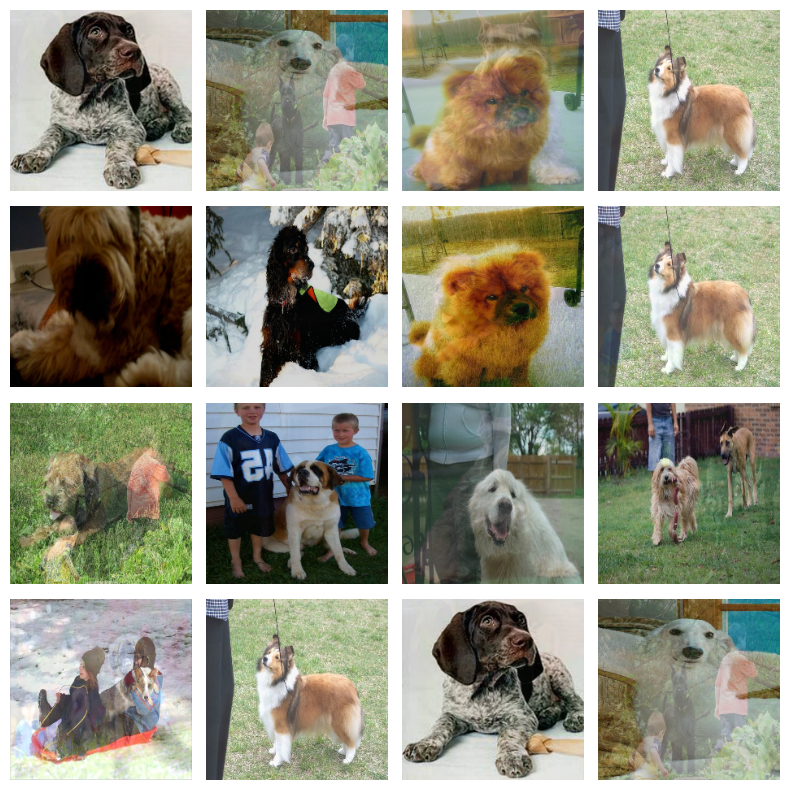

In [28]:
draw_ds(ds_train_mixup)

# Resnet 50

In [20]:
num_classes = 120

In [30]:
resnet50_no = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

94765736/94765736 [==============================] - 0s 0us/step


In [31]:
resnet50_aug = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [21]:
resnet50_cutmix = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [22]:
resnet50_mixup =keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

# 학습

In [25]:
EPOCH = 15
lr = 0.01

### resnet 50 no

In [44]:
resnet50_no.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=lr),
    metrics=['accuracy'],
)

history_resnet50_no = resnet50_no.fit(
    ds_train_no, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
750/750 [==============================] - 191s 227ms/step - loss: 0.2557 - accuracy: 0.9457 - val_loss: 1.0978 - val_accuracy: 0.6913
Epoch 2/15
750/750 [==============================] - 170s 227ms/step - loss: 0.1012 - accuracy: 0.9852 - val_loss: 0.9516 - val_accuracy: 0.7305
Epoch 3/15
750/750 [==============================] - 170s 226ms/step - loss: 0.0501 - accuracy: 0.9958 - val_loss: 0.9496 - val_accuracy: 0.7334
Epoch 4/15
750/750 [==============================] - 170s 227ms/step - loss: 0.0214 - accuracy: 0.9981 - val_loss: 0.9456 - val_accuracy: 0.7397
Epoch 5/15
750/750 [==============================] - 155s 206ms/step - loss: 0.0149 - accuracy: 0.9994 - val_loss: 0.9466 - val_accuracy: 0.7409
Epoch 6/15
750/750 [==============================] - 156s 208ms/step - loss: 0.0081 - accuracy: 0.9998 - val_loss: 0.9436 - val_accuracy: 0.7462
Epoch 7/15
750/750 [==============================] - 170s 227ms/step - loss: 0.0076 - accuracy: 0.9998 - val_loss: 0.9616 -

### resnet 50 augmentation

In [45]:
resnet50_aug.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=lr),
    metrics=['accuracy'],
)

history_resnet50_aug = resnet50_aug.fit(
    ds_train_aug, # augmentation 적용 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
750/750 [==============================] - 191s 228ms/step - loss: 0.4995 - accuracy: 0.8643 - val_loss: 1.0776 - val_accuracy: 0.6877
Epoch 2/15
750/750 [==============================] - 170s 226ms/step - loss: 0.3397 - accuracy: 0.9133 - val_loss: 1.2020 - val_accuracy: 0.6670
Epoch 3/15
750/750 [==============================] - 155s 206ms/step - loss: 0.1705 - accuracy: 0.9651 - val_loss: 0.9751 - val_accuracy: 0.7185
Epoch 4/15
750/750 [==============================] - 154s 206ms/step - loss: 0.1043 - accuracy: 0.9793 - val_loss: 1.0292 - val_accuracy: 0.7171
Epoch 5/15
750/750 [==============================] - 170s 226ms/step - loss: 0.0589 - accuracy: 0.9928 - val_loss: 0.9291 - val_accuracy: 0.7449
Epoch 6/15
750/750 [==============================] - 155s 206ms/step - loss: 0.0366 - accuracy: 0.9961 - val_loss: 0.9673 - val_accuracy: 0.7387
Epoch 7/15
750/750 [==============================] - 154s 206ms/step - loss: 0.0510 - accuracy: 0.9921 - val_loss: 1.0265 -

### resnet 50 cutmix

In [26]:
resnet50_cutmix.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=lr),
    metrics=['accuracy'],
)

history_resnet50_cutmix = resnet50_cutmix.fit(
    ds_train_cutmix, # cutmix 적용 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
750/750 [==============================] - 185s 209ms/step - loss: 3.8772 - accuracy: 0.1972 - val_loss: 2.8363 - val_accuracy: 0.2878
Epoch 2/15
750/750 [==============================] - 158s 211ms/step - loss: 3.0311 - accuracy: 0.4072 - val_loss: 1.4966 - val_accuracy: 0.5756
Epoch 3/15
750/750 [==============================] - 158s 211ms/step - loss: 2.7569 - accuracy: 0.4873 - val_loss: 1.5193 - val_accuracy: 0.5898
Epoch 4/15
750/750 [==============================] - 159s 212ms/step - loss: 2.5941 - accuracy: 0.5420 - val_loss: 1.2683 - val_accuracy: 0.6432
Epoch 5/15
750/750 [==============================] - 158s 211ms/step - loss: 2.4232 - accuracy: 0.5924 - val_loss: 1.1428 - val_accuracy: 0.6783
Epoch 6/15
750/750 [==============================] - 173s 231ms/step - loss: 2.3125 - accuracy: 0.6281 - val_loss: 1.1517 - val_accuracy: 0.6814
Epoch 7/15
750/750 [==============================] - 158s 211ms/step - loss: 2.2402 - accuracy: 0.6508 - val_loss: 1.2224 -

### resnet 50 mixup

In [27]:
resnet50_mixup.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=lr),
    metrics=['accuracy'],
)

history_resnet50_mixup = resnet50_mixup.fit(
    ds_train_mixup, # mixup 적용 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
750/750 [==============================] - 182s 214ms/step - loss: 3.7766 - accuracy: 0.2317 - val_loss: 4.7131 - val_accuracy: 0.0575
Epoch 2/15
750/750 [==============================] - 159s 212ms/step - loss: 2.9571 - accuracy: 0.4443 - val_loss: 1.6743 - val_accuracy: 0.5377
Epoch 3/15
750/750 [==============================] - 158s 211ms/step - loss: 2.7001 - accuracy: 0.5366 - val_loss: 1.3912 - val_accuracy: 0.5931
Epoch 4/15
750/750 [==============================] - 173s 231ms/step - loss: 2.5519 - accuracy: 0.5913 - val_loss: 1.3504 - val_accuracy: 0.6315
Epoch 5/15
750/750 [==============================] - 158s 211ms/step - loss: 2.4063 - accuracy: 0.6379 - val_loss: 1.2648 - val_accuracy: 0.6533
Epoch 6/15
750/750 [==============================] - 158s 211ms/step - loss: 2.3386 - accuracy: 0.6666 - val_loss: 1.3514 - val_accuracy: 0.6276
Epoch 7/15
750/750 [==============================] - 173s 231ms/step - loss: 2.2606 - accuracy: 0.6938 - val_loss: 1.3556 -

# visualization

<ipython-input-36-442df7538bf4>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(411)


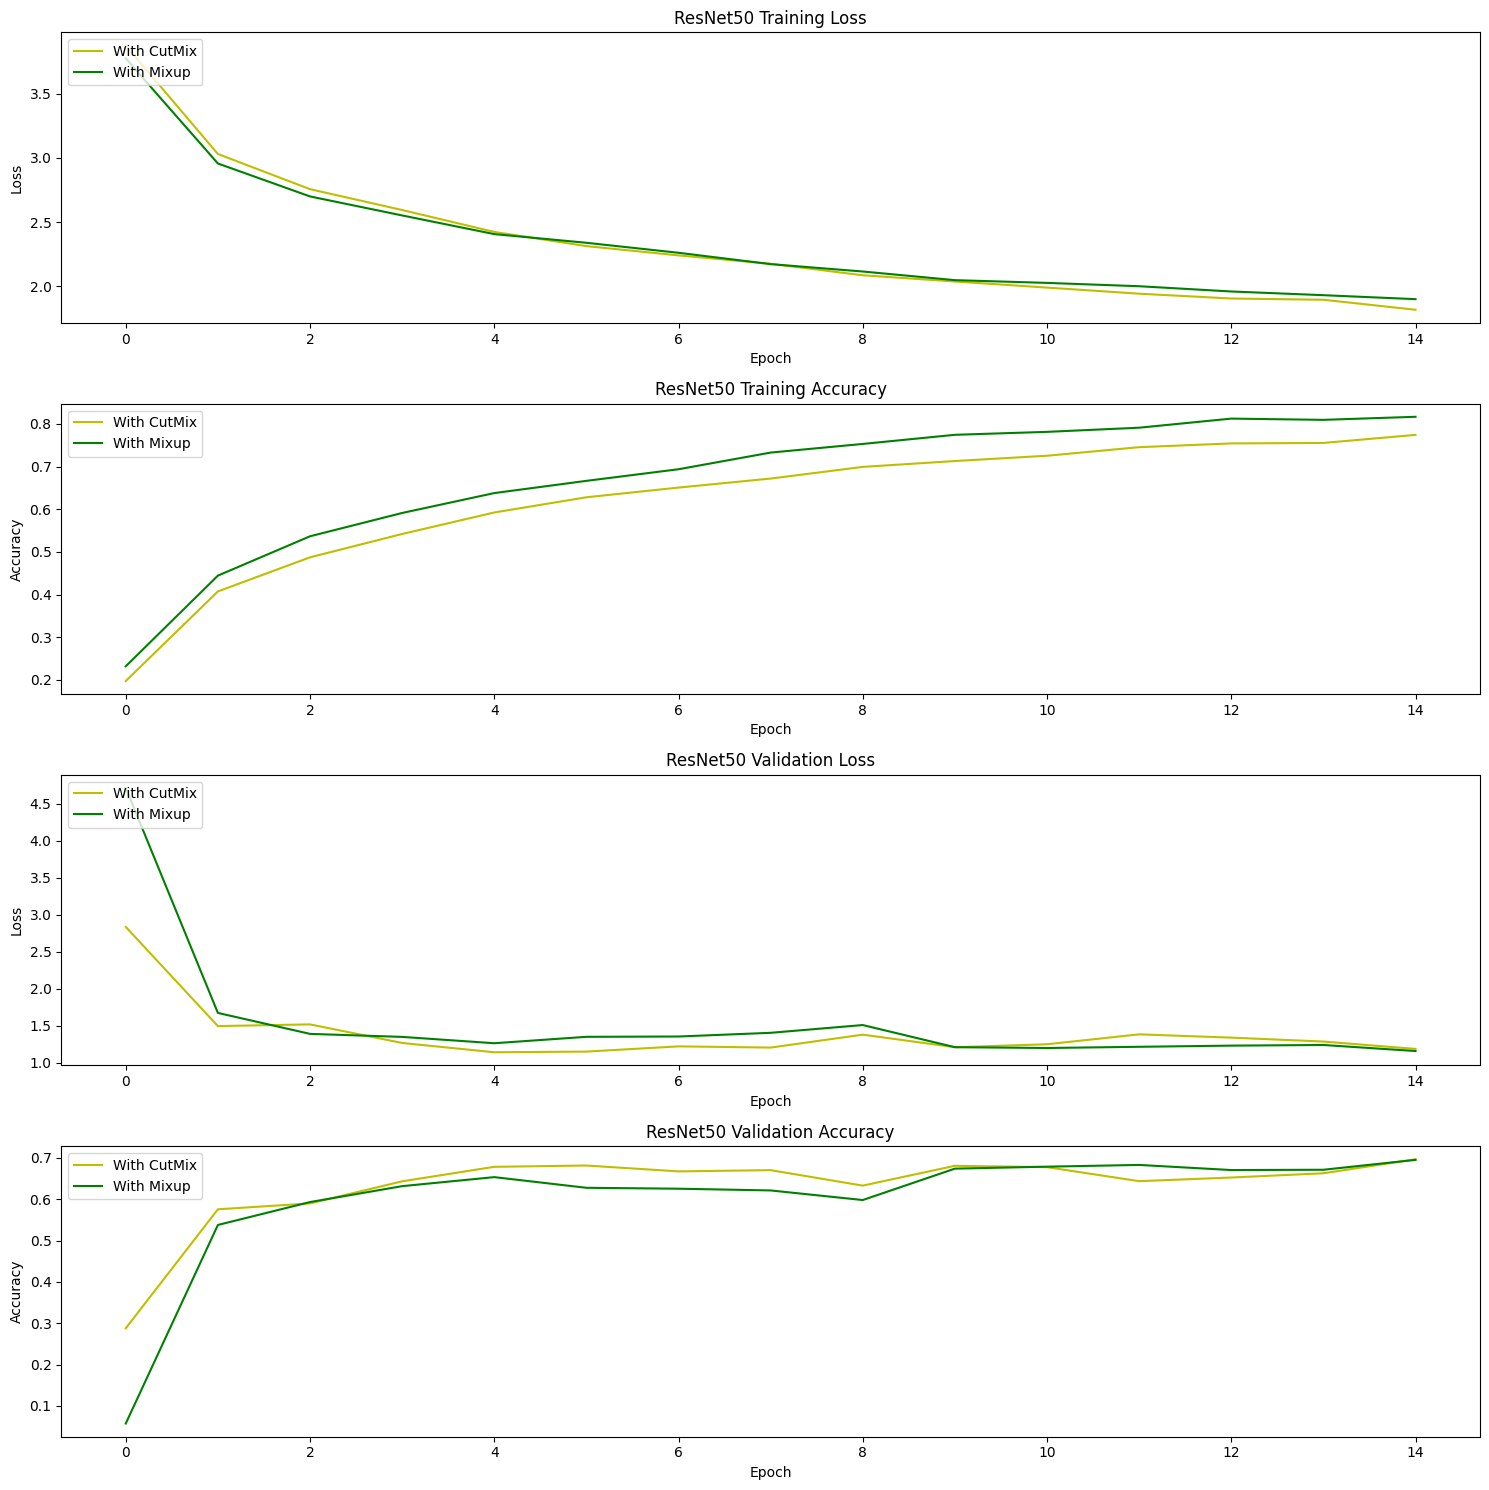

In [36]:
plt.subplots(figsize=(15,15))

# No Aug, With Aug, With CutMix, With Mixup 의 Training Loss 시각화
plt.subplot(411)
#plt.plot(history_resnet50_no.history['loss'], 'r')
#plt.plot(history_resnet50_aug.history['loss'], 'b')
plt.plot(history_resnet50_cutmix.history['loss'], 'y')
plt.plot(history_resnet50_mixup.history['loss'], 'g')
plt.title('ResNet50 Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
# plt.legend(['No Aug', 'With Aug', 'With CutMix', 'With Mixup'], loc='upper left')
plt.legend([ 'With CutMix', 'With Mixup'], loc='upper left')

# No Aug, With Aug, With CutMix, With Mixup 의 Training Accuracy 시각화
plt.subplot(412)
#plt.plot(history_resnet50_no.history['accuracy'], 'r')
#plt.plot(history_resnet50_aug.history['accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['accuracy'], 'y')
plt.plot(history_resnet50_mixup.history['accuracy'], 'g')
plt.title('ResNet50 Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
# plt.legend(['No Aug', 'With Aug', 'With CutMix', 'With Mixup'], loc='upper left')
plt.legend([ 'With CutMix', 'With Mixup'], loc='upper left')

# No Aug, With Aug, With CutMix, With Mixup 의 Validation Loss 시각화
plt.subplot(413)
#plt.plot(history_resnet50_no.history['val_loss'], 'r')
#plt.plot(history_resnet50_aug.history['val_loss'], 'b')
plt.plot(history_resnet50_cutmix.history['val_loss'], 'y')
plt.plot(history_resnet50_mixup.history['val_loss'], 'g')
plt.title('ResNet50 Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
# plt.legend(['No Aug', 'With Aug', 'With CutMix', 'With Mixup'], loc='upper left')
plt.legend([ 'With CutMix', 'With Mixup'], loc='upper left')

# No Aug, With Aug, With CutMix, With Mixup 의 Validation Accuracy 시각화
plt.subplot(414)
#plt.plot(history_resnet50_no.history['val_accuracy'], 'r')
#plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'y')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'g')
plt.title('ResNet50 Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
# plt.legend([ 'No Aug', 'With Aug', 'With CutMix', 'With Mixup'], loc='upper left')
plt.legend([ 'With CutMix', 'With Mixup'], loc='upper left')

plt.tight_layout()
plt.show()

# table

In [32]:
'''
model_result = {
    'resnet 50 no' : [
        round(np.array(history_resnet50_no.history['loss']).mean(), 2),
        round(np.array(history_resnet50_no.history['accuracy']).mean(), 2),
        round(np.array(history_resnet50_no.history['val_loss']).mean(), 2),
        round(np.array(history_resnet50_no.history['val_accuracy']).mean(), 2)
    ],

    'resnet 50 aug' : [
        round(np.array(history_resnet50_aug.history['loss']).mean(), 2),
        round(np.array(history_resnet50_aug.history['accuracy']).mean(), 2),
        round(np.array(history_resnet50_aug.history['val_loss']).mean(), 2),
        round(np.array(history_resnet50_aug.history['val_accuracy']).mean(), 2)
    ],

    'resnet 50 cutmix' : [
        round(np.array(history_resnet50_cutmix.history['loss']).mean(), 2),
        round(np.array(history_resnet50_cutmix.history['accuracy']).mean(), 2),
        round(np.array(history_resnet50_cutmix.history['val_loss']).mean(), 2),
        round(np.array(history_resnet50_cutmix.history['val_accuracy']).mean(), 2)
    ],

    'resnet 50 mixup' : [
        round(np.array(history_resnet50_mixup.history['loss']).mean(), 2),
        round(np.array(history_resnet50_mixup.history['accuracy']).mean(), 2),
        round(np.array(history_resnet50_mixup.history['val_loss']).mean(), 2),
        round(np.array(history_resnet50_mixup.history['val_accuracy']).mean(), 2)
    ]
}
'''

In [ ]:
'''
df_model_result = pd.DataFrame(model_result, index=['Training Loss', 'Training Accuracy', 'Validation Loss', 'Validation Accuracy'])
df_model_result
'''

In [37]:
model_result = {

    'resnet 50 cutmix' : [
        round(np.array(history_resnet50_cutmix.history['loss']).mean(), 2),
        round(np.array(history_resnet50_cutmix.history['accuracy']).mean(), 2),
        round(np.array(history_resnet50_cutmix.history['val_loss']).mean(), 2),
        round(np.array(history_resnet50_cutmix.history['val_accuracy']).mean(), 2)
    ],

    'resnet 50 mixup' : [
        round(np.array(history_resnet50_mixup.history['loss']).mean(), 2),
        round(np.array(history_resnet50_mixup.history['accuracy']).mean(), 2),
        round(np.array(history_resnet50_mixup.history['val_loss']).mean(), 2),
        round(np.array(history_resnet50_mixup.history['val_accuracy']).mean(), 2)
    ]
}

df_model_result = pd.DataFrame(model_result, index=['Training Loss', 'Training Accuracy', 'Validation Loss', 'Validation Accuracy'])
df_model_result

resnet 50 cutmix  resnet 50 mixup
Training Loss                    2.34             2.34
Training Accuracy                0.62             0.67
Validation Loss                  1.39             1.55
Validation Accuracy              0.63             0.60

# 회고

lms kernel이 계속 죽는다...

batch 줄여도 죽는다...

cutmix는 성능이 왜 안좋지?

data양이 적으면 augmentation 쓰면 좋은거 같은데 많으면 쓰면 안되는건가?